# Более простой способ построить фильтрацию

In [3]:
from gtda.graphs import GraphGeodesicDistance

import numpy as np

In [2]:
get_model_directory = lambda series, cut: f"models/{series}_series/{cut}_cut/"
get_model_name = lambda number:  f"m_{number}.h5"
simplexDir = lambda series, cut, number: f"simplexes/{series}_series/{cut}_cut/simp_{number}/"

In [7]:
from keras import models

In [4]:
model_func = lambda series, cut, id: models.load_model(get_model_directory(series, cut) + get_model_name(id))

In [10]:
from scipy.sparse import csr_matrix

def get_relevance(model, outputSize = 1):
    n = len(model.layers) - 1
    layers = model.layers[1:]
    weights = [layer.get_weights()[0] for layer in layers]
    sizes = [len(weight) for weight in weights] + [outputSize]

    data, row, col = [], [], [] 
    offset = 0
    for layer_num in range(len(sizes) - 1, 0, -1):
        old_offset = offset
        offset += sizes[layer_num]
        for j in range(0, sizes[layer_num]):
        
            weight = weights[layer_num - 1]
            weightPlus = weight * (weight > 0)
            
            normalizeFactor = 0
            for i in range(sizes[layer_num - 1]):
                normalizeFactor += weightPlus[i][j]
            for i in range(sizes[layer_num - 1]):
                x, y = i + offset, j + old_offset
                if weightPlus[i][j] != 0:
                    # data.append(np.log((weightPlus[i][j] / normalizeFactor)**(-1)))
                    data.append(weightPlus[i][j])
                    row.append(y)
                    col.append(x)

    return csr_matrix((data, (row, col))) 

In [34]:
tries = 10
log_cuts = [1, 8, 400]

In [8]:
model = model_func(2, 1, 0)

In [11]:
graph = GraphGeodesicDistance(directed=False).fit_transform(get_relevance(model))

In [13]:
from gtda.homology import VietorisRipsPersistence
# 
p = VietorisRipsPersistence(metric="precomputed").fit_transform_plot(graph)

In [27]:
p.shape

(1, 17, 3)

In [28]:
from gtda.diagrams import NumberOfPoints
points = NumberOfPoints()

points.fit_transform(X=p)

array([[16,  0]], dtype=int64)

In [29]:
from gtda.diagrams import PersistenceEntropy

In [32]:
entropy = PersistenceEntropy()
entropy.fit_transform(X=p)

array([[-1., -1.]])

In [33]:
def load_dgm(series, cut, id):
    graph = GraphGeodesicDistance(directed=False).fit_transform(get_relevance(model))
    return VietorisRipsPersistence(metric="precomputed").fit_transform(graph)

In [35]:
dgmss = lambda series: [[load_dgm(series, cut, i) for i in range(tries)] for cut in log_cuts]

In [37]:
dgmss_0 = dgmss(2)

In [38]:
dgmss_1 = dgmss(3)

In [41]:
import matplotlib.pyplot as plt

In [42]:
def draw_plot_func(dgmss, func, title=None):
  y = [[func(dgmss[cut][x]) for x in range(len(dgmss[cut]))] for cut in range(len(dgmss))]
  x = range(1, len(y) + 1)
  fig, ax = plt.subplots()
  ax.boxplot(y)

  ax.set(xlabel='cut by', ylabel='the number',
        title=title)

In [43]:
def draw_homology_num_box(dgmss, dim):
  draw_plot_func(dgmss,
                 lambda dgm: len(dgm[dim]),
                 title ="{}-homologies".format(dim))

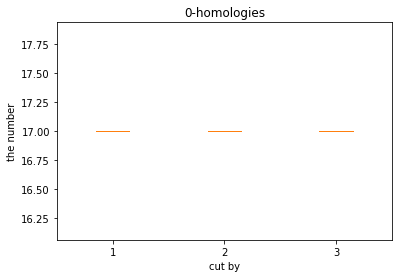

In [45]:
draw_homology_num_box(dgmss_0, 0)